<a href="https://colab.research.google.com/github/sujitojha1/EVA8/blob/main/Session5/EVA8_S5_Normalization_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Normalization and Regularization Effects
### Different trials to study effects of normalization and regularization on CNN model using MNIST dataset 

- Network with Group Normalization
- Network with Layer Normalization
- Network with L1 + BN

## Plotting the loss functions overlayed
## Plotting the misclassification images



## Loading model file

In [1]:
!git clone https://github.com/sujitojha1/EVA8 -q --quiet
!mv EVA8/Session5/*.py .
!rm -rf EVA8

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import *

## Data Transformations


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [4]:
train = datasets.MNIST('./data', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Dataloader Arguments & Test/Train Dataloaders

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Availalbe?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Availalbe? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model Params

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(normalizationMethod='GN').to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0

## Training and Testing

In [7]:
from tqdm import tqdm

train_losses = {"BN":[],"GN":[],"LN":[]}
test_losses = {"BN":[],"GN":[],"LN":[]}
train_acc = {"BN":[],"GN":[],"LN":[]}
test_acc = {"BN":[],"GN":[],"LN":[]}

def train(model, device, train_loader, optimizer, epoch, runName, L1flag=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)


    # L1 Regularization
    if L1flag:
        l1_lambda = 1.0e-5
        l1_loss = torch.tensor(0., requires_grad=True)
        l1_loss=l1_loss.to(device)
        for name, param in model.named_parameters():
            l1_loss = l1_loss + l1_lambda*(torch.norm(param, 1))
        loss=loss+l1_loss

    train_losses[runName].append(loss.item())
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc[runName].append(100*correct/processed)

def test(model, device, test_loader, runName):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses[runName].append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc[runName].append(100. * correct / len(test_loader.dataset))

## Network with Group Normalization

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net(normalizationMethod='GN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 25
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, runName='GN')
    scheduler.step()
    test(model, device, test_loader, runName='GN')

EPOCH: 0


Loss=0.19530463218688965 Batch_id=468 Accuracy=90.11: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s]



Test set: Average loss: 0.0675, Accuracy: 9800/10000 (98.00%)

EPOCH: 1


Loss=0.07679548114538193 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:20<00:00, 22.60it/s]



Test set: Average loss: 0.0427, Accuracy: 9872/10000 (98.72%)

EPOCH: 2


Loss=0.0924190878868103 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]



Test set: Average loss: 0.0445, Accuracy: 9857/10000 (98.57%)

EPOCH: 3


Loss=0.02856375090777874 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]



Test set: Average loss: 0.0336, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.01843097433447838 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:17<00:00, 27.26it/s]



Test set: Average loss: 0.0289, Accuracy: 9910/10000 (99.10%)

EPOCH: 5


Loss=0.06869493424892426 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]



Test set: Average loss: 0.0532, Accuracy: 9825/10000 (98.25%)

EPOCH: 6


Loss=0.03550327196717262 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:17<00:00, 26.55it/s]



Test set: Average loss: 0.0258, Accuracy: 9921/10000 (99.21%)

EPOCH: 7


Loss=0.019165867939591408 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]



Test set: Average loss: 0.0269, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.048064906150102615 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s]



Test set: Average loss: 0.0252, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.047722429037094116 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s]



Test set: Average loss: 0.0268, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


Loss=0.010200625285506248 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:17<00:00, 27.00it/s]



Test set: Average loss: 0.0249, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.02408774010837078 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 27.26it/s]



Test set: Average loss: 0.0257, Accuracy: 9918/10000 (99.18%)

EPOCH: 12


Loss=0.017079144716262817 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 27.50it/s]



Test set: Average loss: 0.0244, Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Loss=0.009903003461658955 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]



Test set: Average loss: 0.0243, Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Loss=0.010887623764574528 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:17<00:00, 27.16it/s]



Test set: Average loss: 0.0243, Accuracy: 9922/10000 (99.22%)

EPOCH: 15


Loss=0.005885748658329248 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:17<00:00, 27.50it/s]



Test set: Average loss: 0.0242, Accuracy: 9923/10000 (99.23%)

EPOCH: 16


Loss=0.021300343796610832 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s]



Test set: Average loss: 0.0240, Accuracy: 9922/10000 (99.22%)

EPOCH: 17


Loss=0.04484095051884651 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 27.13it/s]



Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)

EPOCH: 18


Loss=0.014454112388193607 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:17<00:00, 27.24it/s]



Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)

EPOCH: 19


Loss=0.010149076581001282 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:17<00:00, 27.10it/s]



Test set: Average loss: 0.0240, Accuracy: 9921/10000 (99.21%)

EPOCH: 20


Loss=0.019133487716317177 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 27.17it/s]



Test set: Average loss: 0.0240, Accuracy: 9921/10000 (99.21%)

EPOCH: 21


Loss=0.018402574583888054 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 27.54it/s]



Test set: Average loss: 0.0240, Accuracy: 9921/10000 (99.21%)

EPOCH: 22


Loss=0.020975494757294655 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 26.95it/s]



Test set: Average loss: 0.0240, Accuracy: 9922/10000 (99.22%)

EPOCH: 23


Loss=0.013546482659876347 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 26.58it/s]



Test set: Average loss: 0.0240, Accuracy: 9922/10000 (99.22%)

EPOCH: 24


Loss=0.006571171339601278 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 27.26it/s]



Test set: Average loss: 0.0240, Accuracy: 9922/10000 (99.22%)



In [9]:
# import necessary libraries
import matplotlib.pyplot as plt

# define a function to plot misclassified images
def plot_misclassified_images(model, test_loader):
    # set model to evaluation mode
    model.eval()

    misclassified_images = []
    actual_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    misclassified_images.append(data[i])
                    actual_labels.append(target[i])
                    predicted_labels.append(pred[i])

    # Plot the misclassified images
    fig = plt.figure(figsize=(10, 5))
    for i in range(10):
        sub = fig.add_subplot(2, 5, i+1)
        plt.imshow(misclassified_images[i].cpu().numpy().squeeze(), cmap='gray', interpolation='none')
        sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
    plt.tight_layout()
    plt.show()


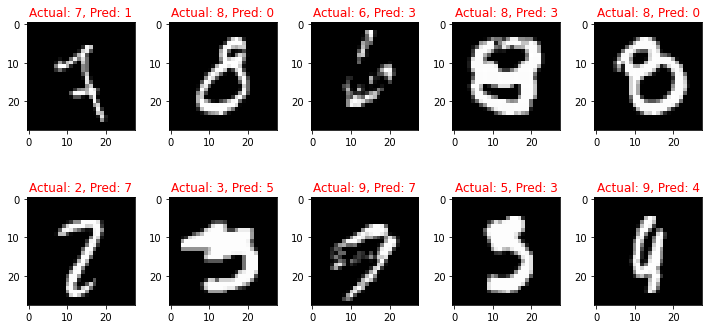

In [10]:
plot_misclassified_images(model, test_loader)

## Network with Layer Normalization

In [11]:
model =  Net(normalizationMethod='LN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 25
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, runName='LN')
    scheduler.step()
    test(model, device, test_loader, runName='LN')

EPOCH: 0


Loss=0.061301302164793015 Batch_id=468 Accuracy=89.57: 100%|██████████| 469/469 [00:22<00:00, 21.32it/s]



Test set: Average loss: 0.0854, Accuracy: 9744/10000 (97.44%)

EPOCH: 1


Loss=0.03560618683695793 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:19<00:00, 24.13it/s]



Test set: Average loss: 0.0454, Accuracy: 9859/10000 (98.59%)

EPOCH: 2


Loss=0.044133853167295456 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:17<00:00, 27.03it/s]



Test set: Average loss: 0.0509, Accuracy: 9849/10000 (98.49%)

EPOCH: 3


Loss=0.09459098428487778 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]



Test set: Average loss: 0.0327, Accuracy: 9895/10000 (98.95%)

EPOCH: 4


Loss=0.08100982755422592 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:17<00:00, 26.76it/s]



Test set: Average loss: 0.0394, Accuracy: 9873/10000 (98.73%)

EPOCH: 5


Loss=0.003954487387090921 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s]



Test set: Average loss: 0.0312, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.06080469861626625 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:17<00:00, 27.08it/s]



Test set: Average loss: 0.0259, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.046354591846466064 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]



Test set: Average loss: 0.0258, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.02750338800251484 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:17<00:00, 27.42it/s]



Test set: Average loss: 0.0262, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.08510052412748337 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 27.13it/s]



Test set: Average loss: 0.0239, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.09781403094530106 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:17<00:00, 26.86it/s]



Test set: Average loss: 0.0245, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.11842891573905945 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 27.40it/s]



Test set: Average loss: 0.0242, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.014322659932076931 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 27.13it/s]



Test set: Average loss: 0.0246, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.011339381337165833 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 27.16it/s]



Test set: Average loss: 0.0244, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.06133592128753662 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:17<00:00, 26.97it/s]



Test set: Average loss: 0.0241, Accuracy: 9926/10000 (99.26%)

EPOCH: 15


Loss=0.0427406020462513 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]



Test set: Average loss: 0.0242, Accuracy: 9926/10000 (99.26%)

EPOCH: 16


Loss=0.033562105149030685 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 26.77it/s]



Test set: Average loss: 0.0243, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


Loss=0.008134015835821629 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:17<00:00, 27.46it/s]



Test set: Average loss: 0.0240, Accuracy: 9928/10000 (99.28%)

EPOCH: 18


Loss=0.036261722445487976 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 27.02it/s]



Test set: Average loss: 0.0240, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=0.006822200957685709 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s]



Test set: Average loss: 0.0240, Accuracy: 9927/10000 (99.27%)

EPOCH: 20


Loss=0.0626014843583107 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:17<00:00, 27.24it/s]



Test set: Average loss: 0.0240, Accuracy: 9927/10000 (99.27%)

EPOCH: 21


Loss=0.024304555729031563 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s]



Test set: Average loss: 0.0239, Accuracy: 9927/10000 (99.27%)

EPOCH: 22


Loss=0.020449746400117874 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 26.63it/s]



Test set: Average loss: 0.0239, Accuracy: 9925/10000 (99.25%)

EPOCH: 23


Loss=0.004090020898729563 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:17<00:00, 27.07it/s]



Test set: Average loss: 0.0239, Accuracy: 9926/10000 (99.26%)

EPOCH: 24


Loss=0.009633840061724186 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 27.02it/s]



Test set: Average loss: 0.0239, Accuracy: 9926/10000 (99.26%)



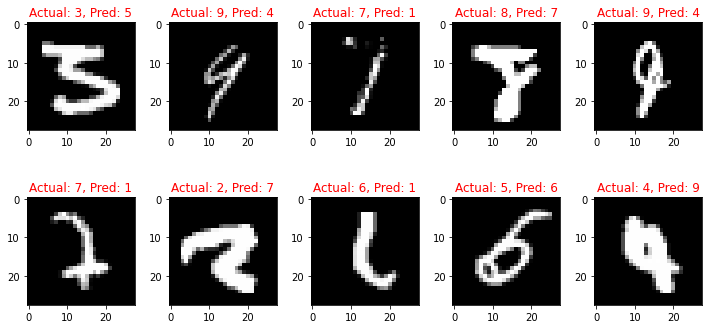

In [12]:
plot_misclassified_images(model, test_loader)

## Network with L1 + BN

In [13]:
model =  Net(normalizationMethod='BN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 25
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, runName='BN',  L1flag=True)
    scheduler.step()
    test(model, device, test_loader, runName='BN')

EPOCH: 0


Loss=0.09183988720178604 Batch_id=468 Accuracy=91.99: 100%|██████████| 469/469 [00:18<00:00, 24.88it/s]



Test set: Average loss: 0.0628, Accuracy: 9807/10000 (98.07%)

EPOCH: 1


Loss=0.08177827298641205 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:18<00:00, 25.63it/s]



Test set: Average loss: 0.0448, Accuracy: 9866/10000 (98.66%)

EPOCH: 2


Loss=0.08181747049093246 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:18<00:00, 25.80it/s]



Test set: Average loss: 0.0304, Accuracy: 9910/10000 (99.10%)

EPOCH: 3


Loss=0.20359593629837036 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:18<00:00, 25.08it/s]



Test set: Average loss: 0.0272, Accuracy: 9915/10000 (99.15%)

EPOCH: 4


Loss=0.06534942984580994 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:18<00:00, 24.96it/s]



Test set: Average loss: 0.0239, Accuracy: 9930/10000 (99.30%)

EPOCH: 5


Loss=0.06607872992753983 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:18<00:00, 25.64it/s]



Test set: Average loss: 0.0265, Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.06525595486164093 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:18<00:00, 25.71it/s]



Test set: Average loss: 0.0206, Accuracy: 9931/10000 (99.31%)

EPOCH: 7


Loss=0.030059296637773514 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:18<00:00, 25.71it/s]



Test set: Average loss: 0.0200, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.03133604675531387 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 26.17it/s]



Test set: Average loss: 0.0194, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Loss=0.054264478385448456 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:18<00:00, 25.85it/s]



Test set: Average loss: 0.0195, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.01886620745062828 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:18<00:00, 25.90it/s]



Test set: Average loss: 0.0192, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.014784293249249458 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:18<00:00, 26.00it/s]



Test set: Average loss: 0.0190, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.010026523843407631 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 26.09it/s]



Test set: Average loss: 0.0188, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.03713136538863182 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:18<00:00, 25.91it/s]



Test set: Average loss: 0.0194, Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.011002222076058388 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:17<00:00, 26.08it/s]



Test set: Average loss: 0.0193, Accuracy: 9937/10000 (99.37%)

EPOCH: 15


Loss=0.037595584988594055 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:18<00:00, 25.93it/s]



Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.38%)

EPOCH: 16


Loss=0.03358294814825058 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:17<00:00, 26.31it/s]



Test set: Average loss: 0.0190, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


Loss=0.014605251140892506 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 26.41it/s]



Test set: Average loss: 0.0189, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.020592842251062393 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:18<00:00, 25.72it/s]



Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.027574148029088974 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:17<00:00, 26.26it/s]



Test set: Average loss: 0.0187, Accuracy: 9938/10000 (99.38%)

EPOCH: 20


Loss=0.04066210985183716 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:18<00:00, 25.98it/s]



Test set: Average loss: 0.0189, Accuracy: 9937/10000 (99.37%)

EPOCH: 21


Loss=0.018719829618930817 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:18<00:00, 25.95it/s]



Test set: Average loss: 0.0192, Accuracy: 9935/10000 (99.35%)

EPOCH: 22


Loss=0.04434162750840187 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:18<00:00, 25.83it/s]



Test set: Average loss: 0.0182, Accuracy: 9939/10000 (99.39%)

EPOCH: 23


Loss=0.04078589752316475 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:17<00:00, 26.41it/s]



Test set: Average loss: 0.0185, Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Loss=0.017712105065584183 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 26.31it/s]



Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.40%)



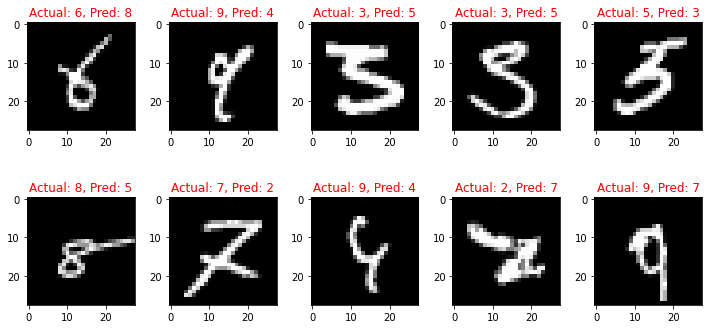

In [14]:
plot_misclassified_images(model, test_loader)

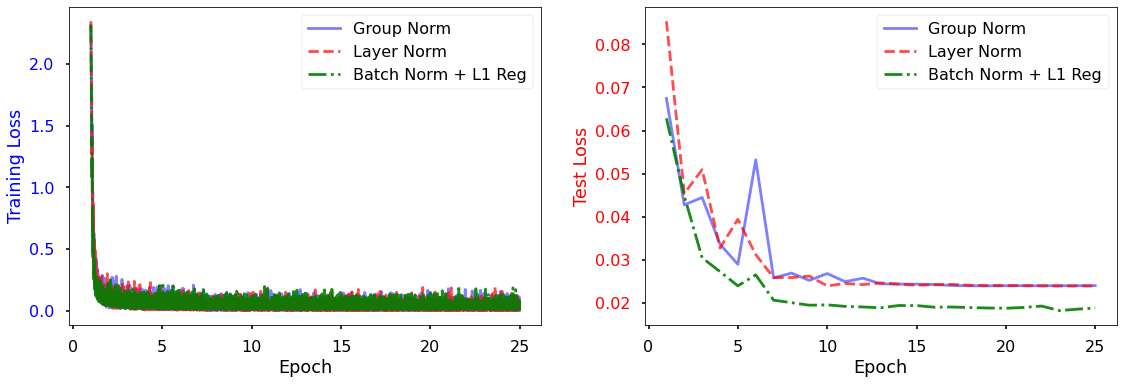

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-poster')

fig, ax = plt.subplots(1, 2)

color1 = 'blue'
color2 = 'red'
color3 = 'green'
linestyle1 = '-'
linestyle2 = '--'
linestyle3 = '-.'

train_epoch_linspace = np.linspace(1, EPOCHS, len(train_losses['GN']))
test_epoch_linspace = np.linspace(1, EPOCHS, len(test_losses['GN']))
#Left plot

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Training Loss', color=color1)
ax[0].plot(train_epoch_linspace, train_losses['GN'], color=color1, linestyle=linestyle1,alpha=0.5, label='Group Norm')
ax[0].plot(train_epoch_linspace, train_losses['LN'], color=color2, linestyle=linestyle2,alpha=0.7, label='Layer Norm')
ax[0].plot(train_epoch_linspace, train_losses['BN'], color=color3, linestyle=linestyle3,alpha=0.9, label='Batch Norm + L1 Reg')
ax[0].tick_params(axis='y', labelcolor=color1)
ax[0].legend(loc='upper right')
#Right plot

ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Test Loss', color=color2)
ax[1].plot(test_epoch_linspace, test_losses['GN'], color=color1, linestyle=linestyle1,alpha=0.5, label='Group Norm')
ax[1].plot(test_epoch_linspace, test_losses['LN'], color=color2, linestyle=linestyle2,alpha=0.7, label='Layer Norm')
ax[1].plot(test_epoch_linspace, test_losses['BN'], color=color3, linestyle=linestyle3,alpha=0.9, label='Batch Norm + L1 Reg')
ax[1].tick_params(axis='y', labelcolor=color2)
ax[1].legend(loc='upper right')

fig.tight_layout()
fig.set_size_inches(16, 5)
plt.show()

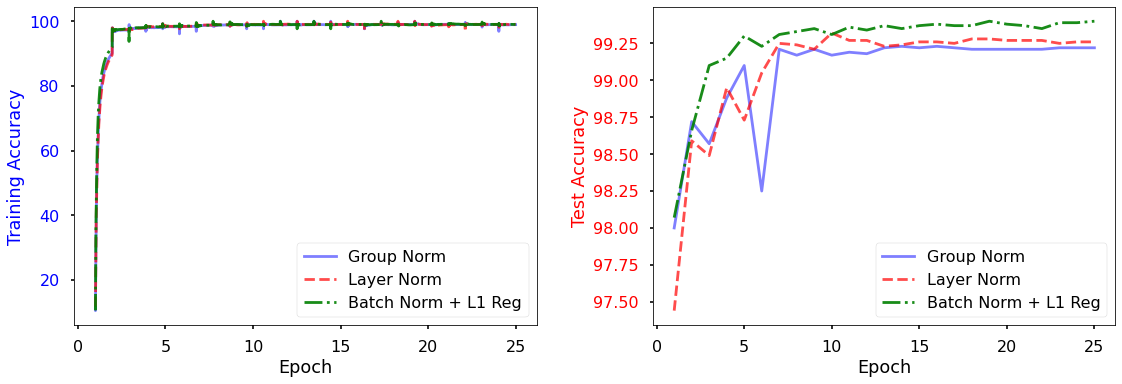

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-poster')

fig, ax = plt.subplots(1, 2)

color1 = 'blue'
color2 = 'red'
color3 = 'green'
linestyle1 = '-'
linestyle2 = '--'
linestyle3 = '-.'

train_epoch_linspace = np.linspace(1, EPOCHS, len(train_acc['GN']))
test_epoch_linspace = np.linspace(1, EPOCHS, len(test_acc['GN']))
#Left plot

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Training Accuracy', color=color1)
ax[0].plot(train_epoch_linspace, train_acc['GN'], color=color1, linestyle=linestyle1,alpha=0.5, label='Group Norm')
ax[0].plot(train_epoch_linspace, train_acc['LN'], color=color2, linestyle=linestyle2,alpha=0.7, label='Layer Norm')
ax[0].plot(train_epoch_linspace, train_acc['BN'], color=color3, linestyle=linestyle3,alpha=0.9, label='Batch Norm + L1 Reg')
ax[0].tick_params(axis='y', labelcolor=color1)
ax[0].legend(loc='lower right')
#Right plot

ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Test Accuracy', color=color2)
ax[1].plot(test_epoch_linspace, test_acc['GN'], color=color1, linestyle=linestyle1,alpha=0.5, label='Group Norm')
ax[1].plot(test_epoch_linspace, test_acc['LN'], color=color2, linestyle=linestyle2,alpha=0.7, label='Layer Norm')
ax[1].plot(test_epoch_linspace, test_acc['BN'], color=color3, linestyle=linestyle3,alpha=0.9, label='Batch Norm + L1 Reg')
ax[1].tick_params(axis='y', labelcolor=color2)
ax[1].legend(loc='lower right')

fig.tight_layout()
fig.set_size_inches(16, 5)
plt.show()